In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/financial-sentiment-analysis


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras_nlp
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
sns.set()

In [3]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df.shape

(5842, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [6]:
df.apply(pd.isnull).sum()

Sentence     0
Sentiment    0
dtype: int64

In [7]:
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

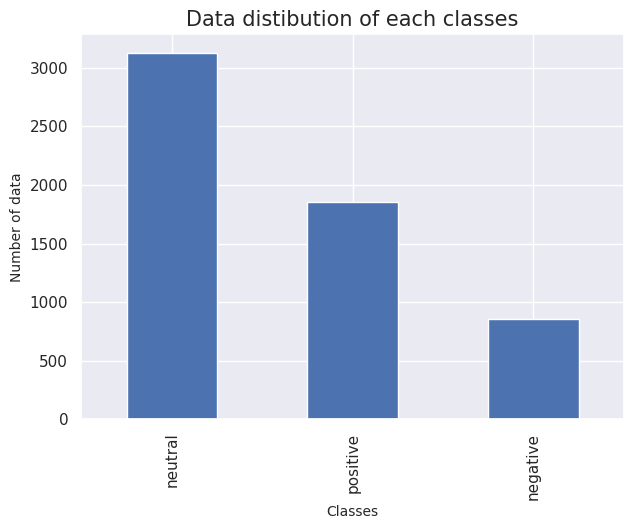

In [8]:
df['Sentiment'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distibution of each classes', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of data', fontsize = 10)
plt.show()

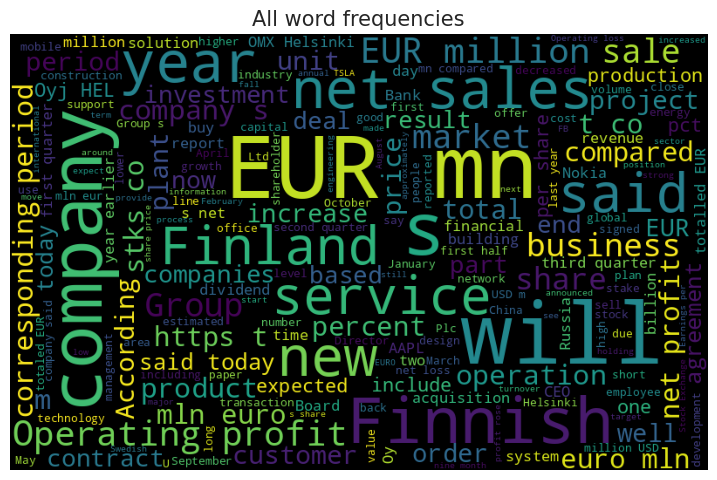

In [9]:
plt.figure(figsize = (9, 9))
all_sents = ' '.join([sentence for sentence in df['Sentence']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title('All word frequencies', fontsize = 15)
plt.axis('off')
plt.show()

In [10]:
def word_cloud(data, sentiment):
    plt.figure(figsize = (9, 9))
    all_sents = ' '.join([sentence for sentence in data['Sentence'][data['Sentiment'] == sentiment]])
    wordcl = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(wordcl)
    plt.title(sentiment, fontsize = 15)
    plt.axis('off')
    plt.show()

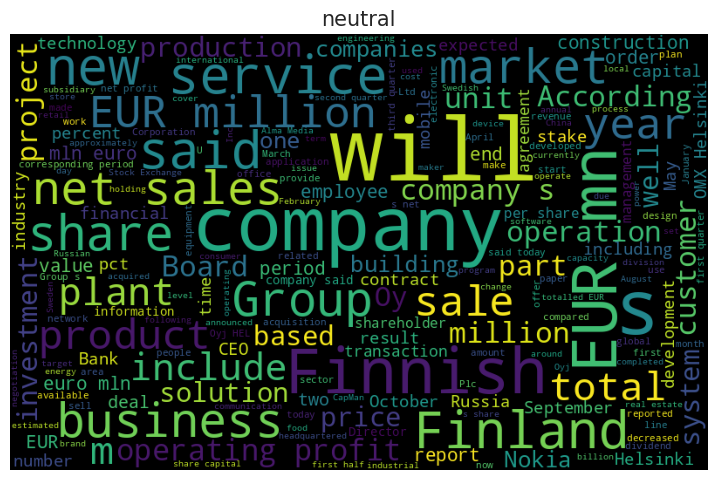

In [11]:
word_cloud(df, 'neutral')

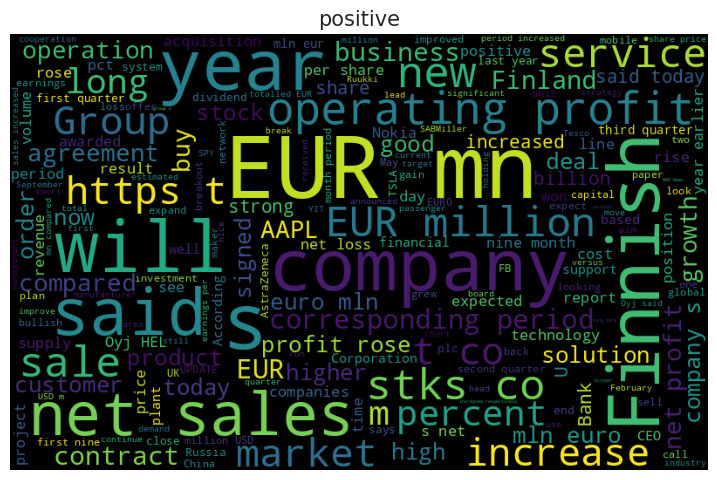

In [12]:
word_cloud(df, 'positive')

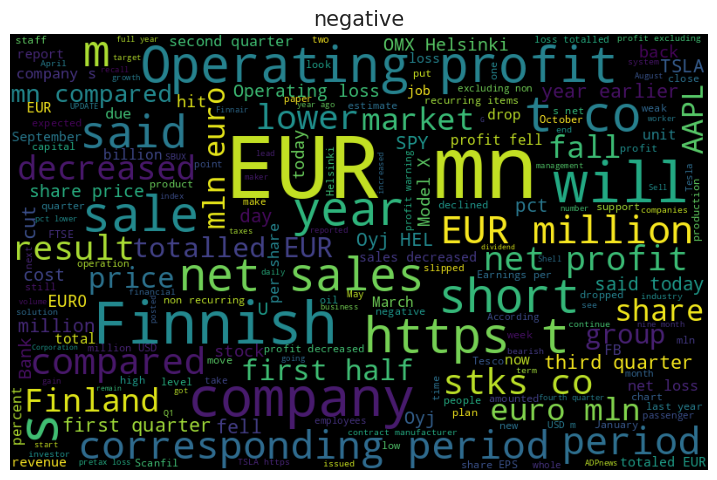

In [13]:
word_cloud(df, 'negative')

In [14]:
df_negative = df[df['Sentiment'] == 'negative']
df_neutral = df[df['Sentiment'] == 'neutral'].sample(df_negative.shape[0])
df_positive = df[df['Sentiment'] == 'positive'].sample(df_negative.shape[0])

In [15]:
df_balanced = pd.concat([df_negative, df_neutral, df_positive])

In [16]:
df_balanced.shape

(2580, 2)

In [17]:
df_balanced['Sentiment'].value_counts()

Sentiment
negative    860
neutral     860
positive    860
Name: count, dtype: int64

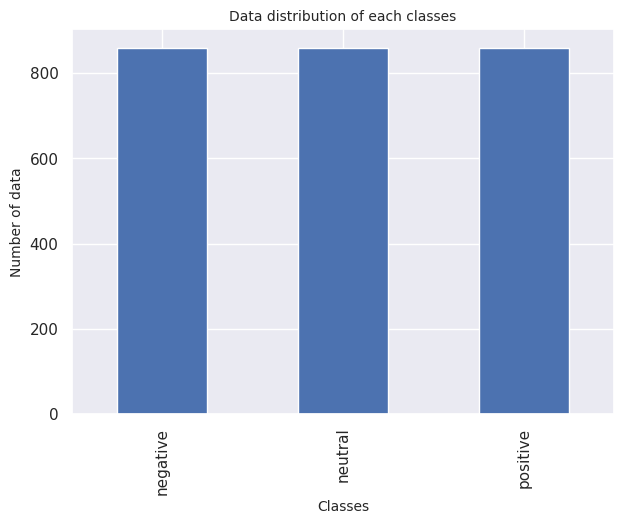

In [18]:
df_balanced['Sentiment'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution of each classes', fontsize = 10)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of data', fontsize = 10)
plt.show()

In [19]:
le = LabelEncoder()

In [20]:
df_balanced['Labels'] = le.fit_transform(df_balanced['Sentiment'])

In [21]:
df_balanced.drop(columns = ['Sentiment'], axis = 1, inplace = True)

In [22]:
df_balanced.head()

,Sentence,Labels
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
6,Shell's $70 Billion BG Deal Meets Shareholder ...,0
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,0
11,$SAP Q1 disappoints as #software licenses down...,0
39,$AAPL afternoon selloff as usual will be bruta...,0


In [23]:
df_balanced.reset_index(drop = True, inplace = True)

In [24]:
df_balanced.head()

,Sentence,Labels
0,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
1,Shell's $70 Billion BG Deal Meets Shareholder ...,0
2,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,0
3,$SAP Q1 disappoints as #software licenses down...,0
4,$AAPL afternoon selloff as usual will be bruta...,0


In [25]:
df_balanced.shape

(2580, 2)

In [26]:
df_balanced0 = df_balanced[df_balanced['Labels'] == 0]
df_balanced1 = df_balanced[df_balanced['Labels'] == 1]
df_balanced2 = df_balanced[df_balanced['Labels'] == 2]

In [27]:
df_balanced0_1 = df_balanced0[: 602]
df_balanced0_2 = df_balanced1[: 602]
df_balanced0_3 = df_balanced2[: 602]

In [28]:
df_train = pd.concat([df_balanced0_1, df_balanced0_2, df_balanced0_3])

In [29]:
df_balanced1_1 = df_balanced0[602: 774]
df_balanced1_2 = df_balanced1[602: 774]
df_balanced1_3 = df_balanced2[602: 774]

In [30]:
df_test = pd.concat([df_balanced1_1, df_balanced1_2, df_balanced1_3])

In [31]:
df_balanced2_1 = df_balanced0[774: ]
df_balanced2_2 = df_balanced1[774: ]
df_balanced2_3 = df_balanced2[774: ]

In [32]:
df_valid = pd.concat([df_balanced2_1, df_balanced2_2, df_balanced2_3])

In [33]:
print('The training set size is:', df_train.shape[0])
print('The test set size is:', df_test.shape[0])
print('The validation set size is:', df_valid.shape[0])

The training set size is: 1806
The test set size is: 516
The validation set size is: 258


In [34]:
X_train = df_train.drop(columns = ['Labels'], axis = 1)
y_train = df_train['Labels']

In [35]:
X_train, y_train = shuffle(X_train, y_train)

In [36]:
X_test = df_test.drop(columns = ['Labels'], axis = 1)
y_test = df_test['Labels']

In [37]:
X_test, y_test = shuffle(X_test, y_test)

In [38]:
X_valid = df_valid.drop(columns = ['Labels'], axis = 1)
y_valid = df_valid['Labels']

In [39]:
X_valid, y_valid = shuffle(X_valid, y_valid)

In [40]:
X_train = tf.ragged.constant(X_train.values)

In [41]:
X_train = tf.convert_to_tensor(X_train.values)

In [42]:
X_test = tf.ragged.constant(X_test.values)

In [43]:
X_test = tf.convert_to_tensor(X_test.values)

In [44]:
X_valid = tf.ragged.constant(X_valid.values)

In [45]:
X_valid = tf.convert_to_tensor(X_valid.values)

In [46]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train.values))

In [47]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test.values))

In [48]:
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid.values))

In [49]:
train_data = train_data.cache().shuffle(1806).prefetch(tf.data.AUTOTUNE).batch(8)

In [50]:
test_data = test_data.cache().shuffle(516).prefetch(tf.data.AUTOTUNE).batch(8)

In [51]:
valid_data = valid_data.cache().shuffle(258).prefetch(tf.data.AUTOTUNE).batch(8)

In [52]:
tokenizer = keras_nlp.models.BertTokenizer.from_preset('bert_small_en_uncased')

In [53]:
processor = keras_nlp.models.BertPreprocessor(
    tokenizer, sequence_length = 80, truncate = 'round_robin'
)

In [54]:
model = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased', preprocessor = processor, num_classes = 3
)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [56]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy'],
    jit_compile = True
)

In [57]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)

In [58]:
history = model.fit(train_data, epochs = 3, validation_data = valid_data)

Epoch 1/3
226/226 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.4491 - loss: 1.0501 - val_accuracy: 0.5930 - val_loss: 0.8948
Epoch 2/3
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5795 - loss: 0.8926 - val_accuracy: 0.6512 - val_loss: 0.7684
Epoch 3/3
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7286 - loss: 0.7050 - val_accuracy: 0.7132 - val_loss: 0.6777


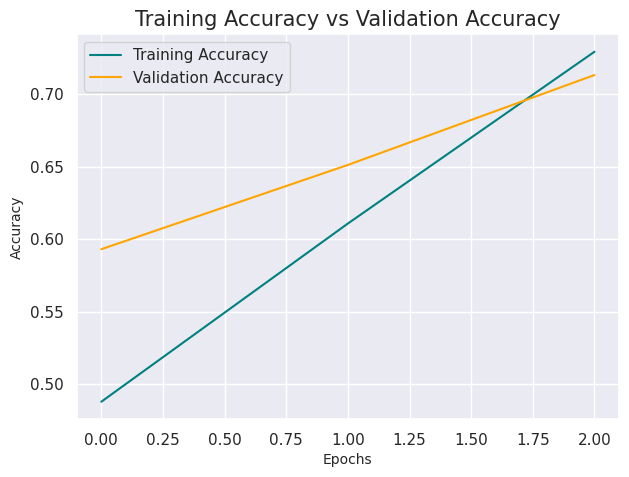

In [63]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

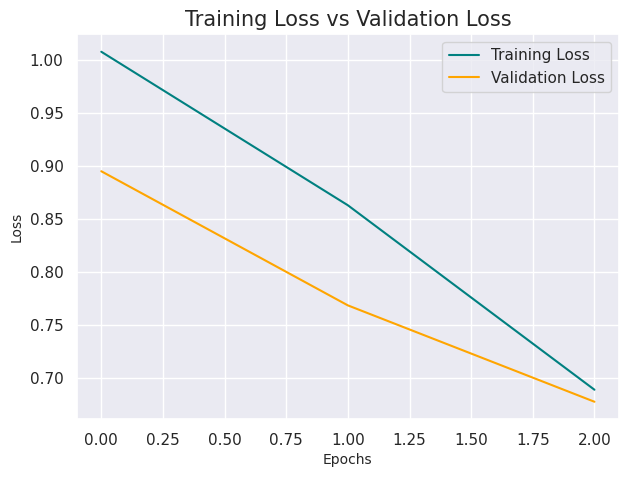

In [65]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [67]:
model.evaluate(test_data)

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6578 - loss: 0.7559


[0.7255548238754272, 0.6763566136360168]